In [26]:
import random
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [27]:
def generate_random_files(byte_size: int):
    random_text: str = ''.join(random.choices(string.ascii_letters + string.digits + string.punctuation + ' ', k = byte_size))
    return random_text

def write_to_file(directory: str, filename: str, byte_size: int):
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory,filename)
    random_text = generate_random_files(byte_size)

    with open(file_path,'w') as file:
        file.write(random_text)

### AES

In [28]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from binascii import hexlify
from numpy import array, mean, var, std, sqrt

import timeit, secrets

In [29]:
def aes_encrypt_file(path: str, key: int, new_path: str = None) -> tuple[int, int]:
    # Generate a random IV (16 bytes for AES)
    iv: bytes = secrets.token_bytes(16)

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()

    # Read the plaintext file in binary mode
    with open(path, "rb") as plaintext_file:
        plaintext = plaintext_file.read()

    # Make sure the plaintext length is a multiple of block size (AES block size is 16 bytes)
    padding_length = 16 - len(plaintext) % 16
    padded_plaintext = plaintext + bytes([padding_length]) * padding_length

    # Encrypt the padded plaintext
    ct: bytes = encryptor.update(padded_plaintext) + encryptor.finalize()

    # Write the ciphertext to a new file
    with open(path if new_path == None else new_path + ".bin", "wb") as cphFile:
        cphFile.write(iv)  # Prepend IV to the ciphertext for decryption later
        cphFile.write(ct)

    # print(f"Encryption successful! File saved as: {new_path or path}")
    return hexlify(key), iv

def aes_decrypt_file(path: str, key: int, new_path: str = None) -> None:
    # Read the ciphertext file
    with open(path, "rb") as cphFile:
        iv: bytes = cphFile.read(16)  # Extract the IV (first 16 bytes)
        ct: bytes = cphFile.read()    # Read the rest as ciphertext

    # Create the cipher
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()

    # Decrypt the ciphertext
    padded_plaintext = decryptor.update(ct) + decryptor.finalize()

    # Remove padding (last byte value determines padding length)
    padding_length = padded_plaintext[-1]
    plaintext = padded_plaintext[:-padding_length]

    # Write the decrypted plaintext to a new file
    with open(path[:-4] if new_path is None else new_path, "wb") as plaintext_file:
        plaintext_file.write(plaintext)

    # print(f"Decryption successful! File saved as: {new_path or path}")

In [30]:
def test_aes(files: list[str], times: int, repeat: int) -> tuple[tuple[float, float, float], tuple[float, float, float]]:
    results: list[list[float]] = [[], []]

    for file in files:
        key: bytes = os.urandom(32)
        iv: bytes = secrets.token_bytes(16)

        path: str = os.path.join(os.path.dirname(file), os.path.basename(file))
        with open(path, "rb") as plaintext_file:
            plaintext = plaintext_file.read()

        padding_length = 16 - len(plaintext) % 16
        padded_plaintext = plaintext + bytes([padding_length]) * padding_length

        encrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize(),
            number=times,
            repeat=repeat
        ))

        ct: bytes = Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) + \
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize()

        decrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().update(ct) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().finalize(),
            number=times,
            repeat=repeat
        ))

        results[0].extend(encrypt_trials)
        results[1].extend(decrypt_trials)

    mean_encrypt = mean(results[0])
    mean_decrypt = mean(results[1])

    var_encrypt = var(results[0], ddof=1)
    var_decrypt = var(results[1], ddof=1)

    stderr_encrypt = std(results[0], ddof=1) / sqrt(len(results[0]))
    stderr_decrypt = std(results[1], ddof=1) / sqrt(len(results[1]))

    return (
        (mean_encrypt, var_encrypt, stderr_encrypt),
        (mean_decrypt, var_decrypt, stderr_decrypt)
    )


In [31]:
def print_results(test: str, result: tuple[tuple[float, float, float], tuple[float, float, float]]) -> None:
    print(f"Test {test}:")
    print(f"\tencryption:\n\t\tmean: {result[0][0]:.5f}\n\t\tstd error: {result[0][1]:.5e}\n\t\tvariance: {result[0][2]:.5e}")
    print(f"\tdecryption:\n\t\tmean: {result[1][0]:.5f}\n\t\tstd error: {result[1][1]:.5e}\n\t\tvariance: {result[1][2]:.5e}")

def plot_all_results(tests: list[str], sizes: list[int], results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    x = np.arange(len(tests))
    
    means_encrypt = [result[0][0] for result in results]
    means_decrypt = [result[1][0] for result in results]
    std_errors_encrypt = [result[0][1] for result in results]
    std_errors_decrypt = [result[1][1] for result in results]
    
    # First plot (Standard test names on x-axis)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(x, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(x, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(x, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_ylabel("Time (seconds)")
    ax.set_title("AES Performance for Different Tests")
    ax.set_xticks(x)
    ax.set_xticklabels(tests, rotation=45, ha="right")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Second plot (Actual input sizes in bytes on x-axis)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(sizes, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(sizes, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(sizes, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_xscale("log", base = 10)
    ax.set_yscale("log", base = 10)
    ax.set_xlabel("Input Size (Bytes)")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("AES Performance vs Input Size")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def print_confidence_interval(mean: float, std_dev: float, label: str) -> None:
    confidence_interval = stats.norm.interval(0.99, loc=mean, scale=std_dev)
    print(f"{label} 99% Confidence Interval: ({(pow(10, 6) * confidence_interval[0]):.3f}, {(pow(10, 6) * confidence_interval[1]):.3f}) µs")

def print_all_confidence_intervals(results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    for i, result in enumerate(results):
        print_confidence_interval(result[0][0], result[0][1], f"Encryption Test {i+1}")
        print_confidence_interval(result[1][0], result[1][1], f"Decryption Test {i+1}")

In [32]:
sizes: int = [8, 64, 512, 4096, 32768, 262144, 2097152]
directory: str = "random_files"

amount: int = 10
for size in sizes:
    for i in range(amount):
        filename: str = f'random_text_{size}_{i}.txt'
        write_to_file(directory, filename, size)

files: list[str] = [[directory + f"/random_text_{size}_{i}.txt" for i in range(amount)] for size in sizes]


Same File for Different Sizes


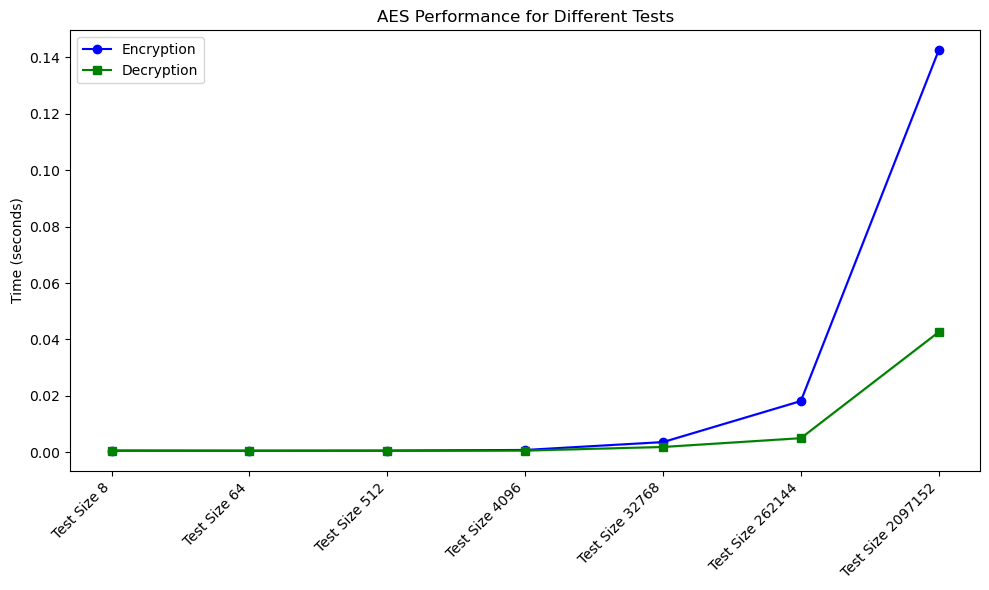

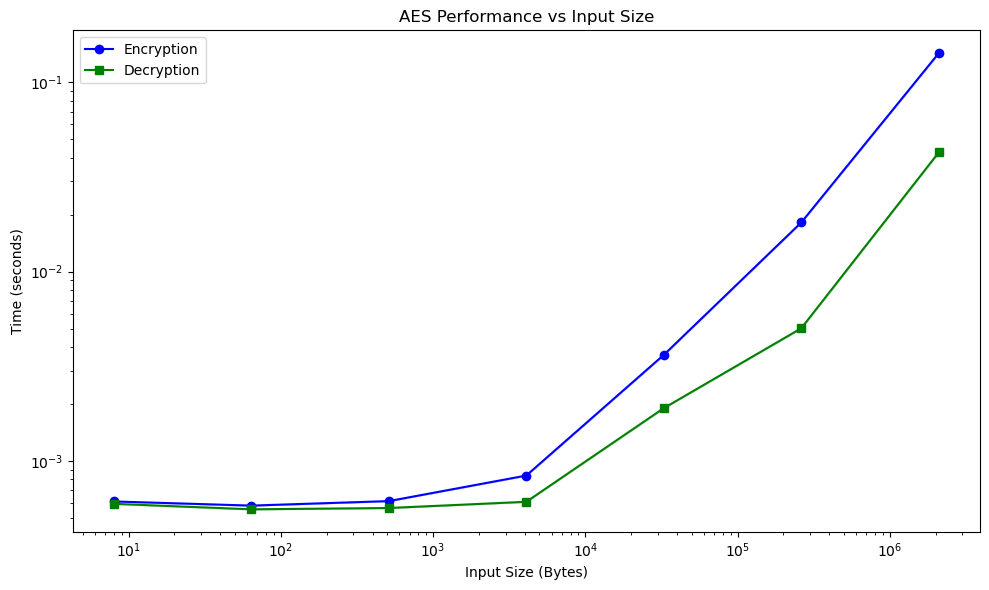

In [33]:
results = []
print("\nSame File for Different Sizes")
for i in range(len(sizes)):
    result = test_aes([files[i][0]], 100, 25)
    results.append(result)
    # print_results(sizes[i], result)
plot_all_results([f"Test Size {size}" for size in sizes], sizes, results)


Random Files for Different Sizes


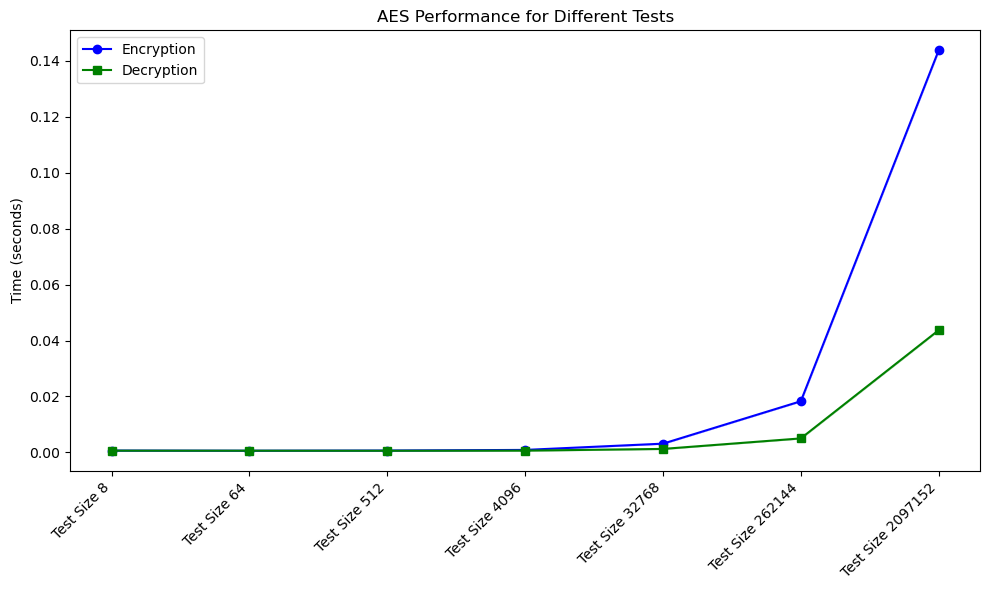

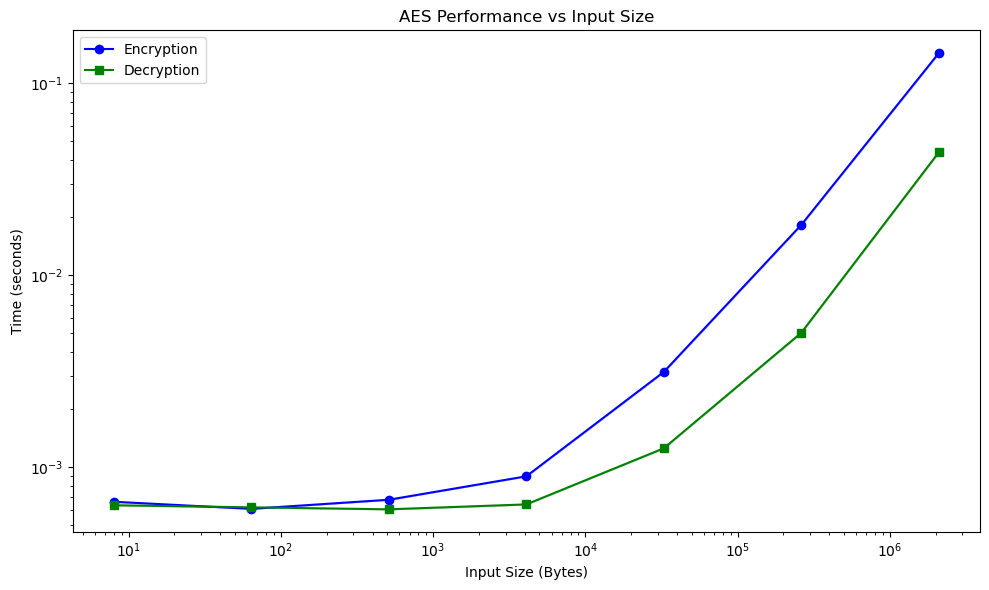

In [34]:
results = []
print("\nRandom Files for Different Sizes")
for i in range(len(sizes)):
    result = test_aes([files[i][0]], 100, 25)
    results.append(result)
    # print_results(sizes[i], result)
plot_all_results([f"Test Size {size}" for size in sizes],sizes, results)

In [35]:
print_all_confidence_intervals(results)

Encryption Test 1 99% Confidence Interval: (659.103, 659.127) µs
Decryption Test 1 99% Confidence Interval: (632.034, 632.046) µs
Encryption Test 2 99% Confidence Interval: (605.446, 605.454) µs
Decryption Test 2 99% Confidence Interval: (616.384, 616.393) µs
Encryption Test 3 99% Confidence Interval: (675.203, 675.211) µs
Decryption Test 3 99% Confidence Interval: (601.914, 601.923) µs
Encryption Test 4 99% Confidence Interval: (894.598, 894.612) µs
Decryption Test 4 99% Confidence Interval: (638.518, 638.526) µs
Encryption Test 5 99% Confidence Interval: (3131.332, 3131.625) µs
Decryption Test 5 99% Confidence Interval: (1251.999, 1252.207) µs
Encryption Test 6 99% Confidence Interval: (18296.354, 18298.020) µs
Decryption Test 6 99% Confidence Interval: (5009.056, 5009.754) µs
Encryption Test 7 99% Confidence Interval: (143679.173, 143808.981) µs
Decryption Test 7 99% Confidence Interval: (43685.809, 43711.572) µs


### SHA-256

In [36]:
from cryptography.hazmat.primitives import hashes
from timeit import default_timer as timer

In [37]:
def compute_sha256(file_path: str) -> tuple[float, bytes]:
    digest = hashes.Hash(hashes.SHA256())

    with open(file_path, 'rb') as file:
        data = file.read()

    start = timer()
    digest.update(data)
    hashing = digest.finalize()
    end = timer()

    elapsed_time_us = (end - start) * 1000000  
    return elapsed_time_us, hashing

def file_time(filename: str) -> float:
    time, _ = compute_sha256(filename)
    return time

def print_results(test: str, result: tuple[float, float, float]) -> None:
    print(f"Test {test}:")
    print(f"\t\tmean: {result[0][0]:.5f}\n\tvariance: {result[0][1]:.5e}\n\std error: {result[0][2]:.5e}")

In [38]:
def test_sha256(filenames: list[str]) -> tuple[float, float, float]:
    results = [file_time(filename) for filename in filenames]
    return (mean(results), var(results, ddof = 1), std(results, ddof = 1) / sqrt(len(filenames)))

def test_sha256_single(filename: str, s_iterations: int) -> tuple[float, float, float]:
    return test_sha256([filename for _ in range(s_iterations)])

In [39]:
def compare_variation(sizes: list[int], results1: list[tuple[float, float, float]], results2: list[tuple[float, float, float]], labels: list[str]) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, [mean for mean, _, _ in results1], marker='o', linestyle='-', color='b', label=labels[0])
    plt.plot(sizes, [mean for mean, _, _ in results2], marker='s', linestyle='--', color='r', label=labels[1])

    plt.xlabel("File Size (Bytes)")
    plt.ylabel("Time (Microseconds)")
    plt.title("SHA Digest Generation: Same vs Different Files")
    plt.xscale("log", base = 10) 
    plt.yscale("log", base = 10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

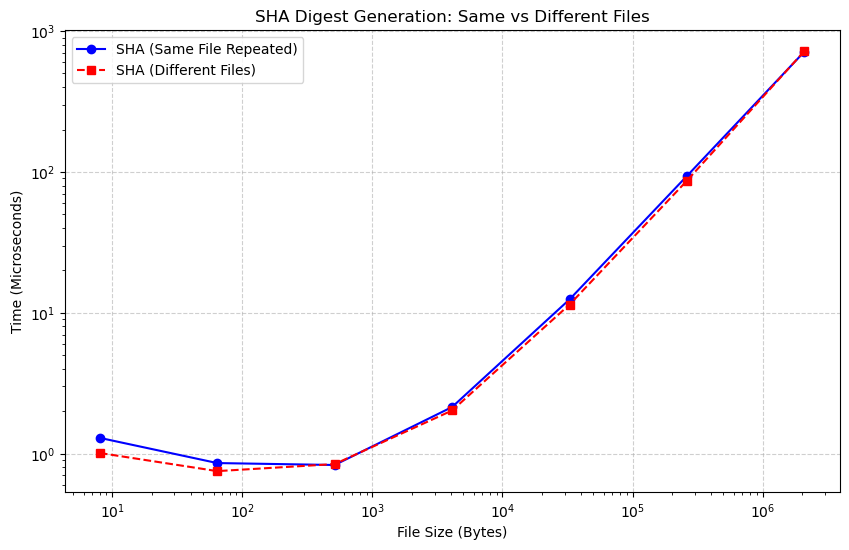

SHA-256 - File Size 8 99% Confidence Interval: (682417.790, 1334381.618) µs
SHA-256 - File Size 64 99% Confidence Interval: (731864.496, 767735.470) µs
SHA-256 - File Size 512 99% Confidence Interval: (835672.125, 847327.812) µs
SHA-256 - File Size 4096 99% Confidence Interval: (2011644.188, 2030156.451) µs
SHA-256 - File Size 32768 99% Confidence Interval: (11416392.708, 11425207.295) µs
SHA-256 - File Size 262144 99% Confidence Interval: (86604325.687, 86612673.923) µs
SHA-256 - File Size 2097152 99% Confidence Interval: (-2630310078.896, 4071409879.546) µs


In [40]:
sha_times_same: list[tuple[float, float, float]] = [test_sha256_single(files[i][0], s_iterations = 100) for i in range(len(sizes))]
sha_times_different: list[tuple[float, float, float]] = [test_sha256(files[i]) for i in range(len(sizes))]

compare_variation(sizes, sha_times_same, sha_times_different, ["SHA (Same File Repeated)", "SHA (Different Files)"])

for i, size in enumerate(sizes):
    print_confidence_interval(sha_times_different[i][0], sha_times_different[i][1], f"SHA-256 - File Size {size}")

### RSA

Public and Private Key generation

In [41]:
from cryptography.hazmat.primitives.asymmetric import rsa 

private_key = rsa.generate_private_key(
    public_exponent=65537,
    key_size=2048
)

public_key=private_key.public_key()

In [42]:
rsa_directory='random_rsa_files'
def generate_rsa_files():
    RSA_sizes=[2 , 4, 8, 16, 32, 64, 128]
    for size in RSA_sizes:

        filename = f'random_text_{size}.txt'
        write_to_file(rsa_directory,filename,size)

Encryption

In [43]:
from cryptography.hazmat.primitives.asymmetric import padding

def rsa_encryption(plaintext, public_key):
    start=timer()
    ciphertext=public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),

            algorithm=hashes.SHA256(),

            label=None
        )
    )

    end=timer()
    encryption_time :float = (end-start)*1000   # ms

    return encryption_time, ciphertext

Decryption

In [44]:
def rsa_decryption(ciphertext, private_key):
    start= timer()
    plaintext = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),

            algorithm=hashes.SHA256(),

            label=None
        )
    )
    end= timer()
    decryption_time : float = (end-start) *1000 # ms 
    
    return decryption_time

Plaintext reading from files

In [45]:
def rsa_encrypt_decrypt(plaintext):

    encrypt_time, ciphertext = rsa_encryption(plaintext, public_key)

    decrypt_time = rsa_decryption(ciphertext, private_key)

    return encrypt_time, decrypt_time

In [46]:
def plot_rsa_performance(file_info):

    file_sizes = sorted(file_info.keys())

    mean_encrypt = [file_info[size][0] for size in file_sizes]
    mean_decrypt = [file_info[size][1] for size in file_sizes]

    var_encrypt = [file_info[size][2] for size in file_sizes]
    var_decrypt = [file_info[size][3] for size in file_sizes]

    stderr_encrypt = [file_info[size][4] for size in file_sizes]
    stderr_decrypt = [file_info[size][5] for size in file_sizes]


    x_positions = range(len(file_sizes))  # Evenly spaced x positions

    plt.figure(figsize=(10, 6))
    
    # Média com barras de erro    
    scale_factor = 7
    plt.errorbar(x_positions, mean_encrypt, yerr=np.array(stderr_encrypt) * scale_factor, fmt='o-', capsize=5, label="Encryption Time (Avg ± StdErr)", color="blue")
    plt.errorbar(x_positions, mean_decrypt, yerr=np.array(stderr_decrypt) * scale_factor, fmt='s-', capsize=5, label="Decryption Time (Avg ± StdErr)", color="red")

    # Variância como área sombreada
    plt.fill_between(x_positions, np.array(mean_encrypt) - np.sqrt(var_encrypt), np.array(mean_encrypt) + np.sqrt(var_encrypt), color="blue", alpha=0.2)
    plt.fill_between(x_positions, np.array(mean_decrypt) - np.sqrt(var_decrypt), np.array(mean_decrypt) + np.sqrt(var_decrypt), color="red", alpha=0.2)


    plt.xticks(x_positions, file_sizes, rotation=45, ha="right")  # Rotate labels for readability
    plt.xlabel("Files")
    plt.ylabel("Time (s)")
    plt.title("RSA Encryption & Decryption Time by File")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
def process_file_info(file_info):

    final_file_info = {}

    for file_size, times in file_info.items():

        encrypt_times = np.array(times["encrypt_times"])
        decrypt_times = np.array(times["decrypt_times"])

        mean_encrypt = np.mean(encrypt_times)
        mean_decrypt = np.mean(decrypt_times)

        var_encrypt = np.var(encrypt_times, ddof=1)  # ddof=1 para variância amostral
        var_decrypt = np.var(decrypt_times, ddof=1)

        stderr_encrypt = np.sqrt(var_encrypt / len(encrypt_times))  # Erro padrão
        stderr_decrypt = np.sqrt(var_decrypt / len(decrypt_times))

        final_file_info[file_size] = [mean_encrypt, mean_decrypt, var_encrypt, var_decrypt, stderr_encrypt, stderr_decrypt]

    return final_file_info

In [48]:
from collections import defaultdict

def get_same_file_info():

    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})
    
    for filename in os.listdir(directory):

        filepath= os.path.join(directory,filename)
        
        if os.path.isfile(filepath):

            with open(filepath, "r", encoding="utf-8") as file:
                
                plaintext=file.read().encode()

            file_size = os.path.getsize(filepath)

            for _ in range(1000):
                e_time, d_time = rsa_encrypt_decrypt(plaintext)

                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)

    return file_info

In [49]:
def get_rand_file_info():
    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})

    for i in range(100):
        
        generate_rsa_files()
        for filename in os.listdir(rsa_directory):

            filepath= os.path.join(rsa_directory,filename)
            
            if os.path.isfile(filepath):

                with open(filepath, "r", encoding="utf-8") as file:
                    
                    plaintext=file.read().encode()

                file_size = os.path.getsize(filepath)

                e_time, d_time = rsa_encrypt_decrypt(plaintext)
                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)
    return file_info

In [50]:
file_info=get_same_file_info()
final_file_info=process_file_info(file_info)
plot_rsa_performance(final_file_info)

file_info= get_rand_file_info()
final_file_info=process_file_info(file_info)
plot_rsa_performance(final_file_info)

ValueError: Encryption failed

In [ ]:
for i in range(len(sizes)):
    for file in files[i]:
        if os.path.isfile(file):
            os.remove(file)